(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Import project package
import Antibiotic
import Antibiotic.mh as mh

# Load CairoMakie for plotting
using CairoMakie
import PairPlots
import ColorSchemes

# Import basic math libraries
import StatsBase
import LinearAlgebra
import Random
import Distributions
import Distances

# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.theme_makie!()

# Simulating Fitnotype profiles

In this notebook, we will use the previously-developed Metropolis-Hastings
evolutionary dynamics algorithm to simulate the evolution of strains on a
fitness-mutational landscape and generate fitnotypic profiles.

The idea is the following: We will define a **single** mutational landscape and
an evolution-condition fitness landscape. Then, we will use the Metropolis-
Hastings algorithm to simulate the evolution of strains on this landscape.
Finally, to simulate the fitnotype profiles, we will determine the fitness of
the different evolving populations in a set of random fitness landscapes
different from the evolution condition landscape.

## 2D Example


Let's start with a simple 2D example. We will define a single central fitness
peak for the evolution condition landscape and four mutational depressions
surrounding it.

In [2]:
# Define peak parameters
fit_amplitude = 5.0
fit_mean = [0.0, 0.0]
fit_covariance = [3.0 0.0; 0.0 3.0]
# Create peak
fit_peak = mh.GaussianPeak(fit_amplitude, fit_mean, fit_covariance)
# Define peak parameters
mut_amplitude = 1.0
mut_means = [
    [-1.5, -1.5],
    [1.5, -1.5],
    [1.5, 1.5],
    [-1.5, 1.5],
]
mut_covariance = [0.45 0.0; 0.0 0.45]

# Create peak
mut_peaks = mh.GaussianPeak.(Ref(mut_amplitude), mut_means, Ref(mut_covariance))

4-element Vector{Antibiotic.mh.GaussianPeak}:
 Antibiotic.mh.GaussianPeak(1.0, [-1.5, -1.5], [0.45 0.0; 0.0 0.45])
 Antibiotic.mh.GaussianPeak(1.0, [1.5, -1.5], [0.45 0.0; 0.0 0.45])
 Antibiotic.mh.GaussianPeak(1.0, [1.5, 1.5], [0.45 0.0; 0.0 0.45])
 Antibiotic.mh.GaussianPeak(1.0, [-1.5, 1.5], [0.45 0.0; 0.0 0.45])

Let's plot the landscapes.

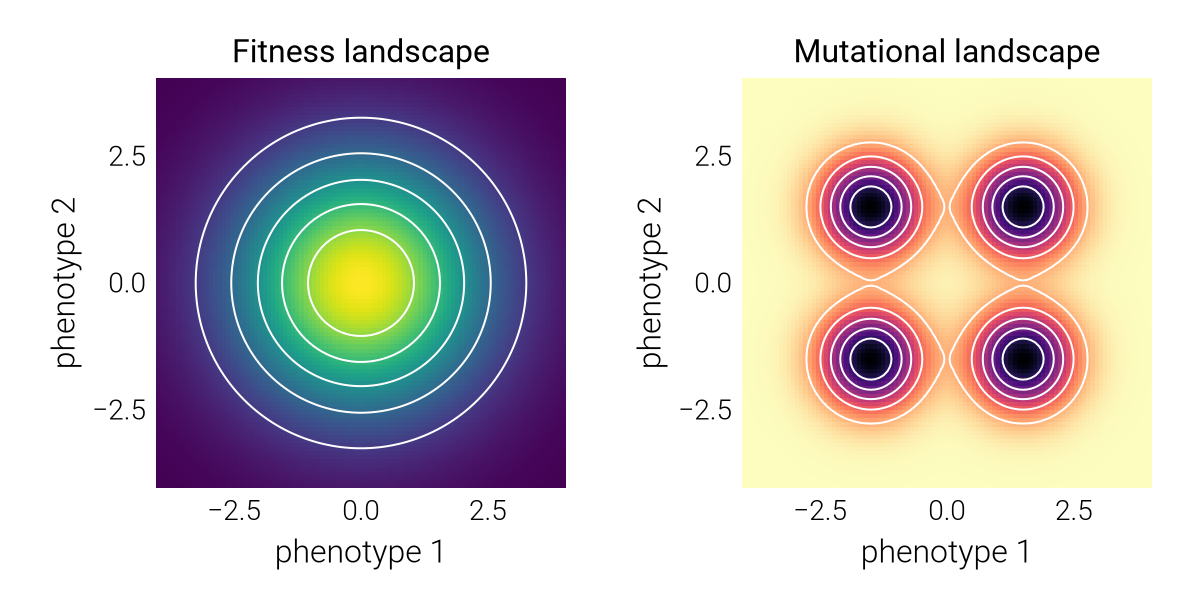

In [21]:
# Define range of phenotypes to evaluate
x = range(-4, 4, length=100)
y = range(-4, 4, length=100)

# Create meshgrid
F = mh.fitness.([[x, y] for x in x, y in y], Ref(fit_peak))
M = mh.mutational_landscape.([[x, y] for x in x, y in y], Ref(mut_peaks))

# Initialize figure
fig = Figure(size=(600, 300))

# Add axis for trajectory in fitness landscape
ax1 = Axis(
    fig[1, 1],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    aspect=AxisAspect(1),
    title="Fitness landscape",
)
# Add axis for trajectory in mutational landscape
ax2 = Axis(
    fig[1, 2],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    aspect=AxisAspect(1),
    title="Mutational landscape",
)

# Plot a heatmap of the fitness landscape
heatmap!(ax1, x, y, F, colormap=:viridis)
# Plot heatmap of mutational landscape
heatmap!(ax2, x, y, M, colormap=:magma)

# Plot contour plot
contour!(ax1, x, y, F, color=:white)
contour!(ax2, x, y, M, color=:white)

fig

### Simulate evolution

Now, we will use the Metropolis-Hastings algorithm to simulate the evolution of
strains on this landscape.

In [23]:
Random.seed!(42)

# Define number of simulations
n_sim = 10

# Select initial conditions relatively close to each other
x0 = rand(Distributions.MvNormal([-2.5, -2.5], 0.1), n_sim)

# Set evolution parameters
β = 10.0
µ = 0.1
n_steps = 300

# Run Metropolis-Hastings algorithm
x_traj_list = [
    mh.evo_metropolis_hastings(x, fit_peak, mut_peaks, β, µ, n_steps)
    for x in eachcol(x0)
]

10-element Vector{Matrix{Float64}}:
 [-2.5363357481451776 -2.63288479684715 … 0.26866220931741935 0.12138514220181246; -2.474826278442577 -2.3782602034869376 … 0.36272453720260805 0.40361585145389683]
 [-2.5314987971168956 -2.5971368156330294 … -1.5280070159387704 -1.5348573593424781; -2.5311252401324422 -2.5973006648652417 … -2.6122052826431945 -2.575675886035675]
 [-2.4183693235067674 -2.277734897879823 … 0.14913156687841891 0.062400014740596615; -2.452326162016812 -2.520442821263324 … -1.1385642627231243 -1.2525567189735929]
 [-2.585955538206162 -2.7137470994649235 … -4.860930272623391 -4.762368437309592; -2.6469288205506545 -2.7607438024821334 … -2.8645519145665683 -2.764341485698429]
 [-2.7114334831130984 -2.656535033895191 … -0.13252655694572668 -0.1329595243509853; -2.495621833796939 -2.4521306760981254 … -0.07126150210597504 -0.10991537438256832]
 [-2.582533454997507 -2.544833780279284 … -2.340470194806558 -2.409806908541791; -2.415971147675418 -2.43944166424436 … -0.0386919096

Let's plot the trajectories.

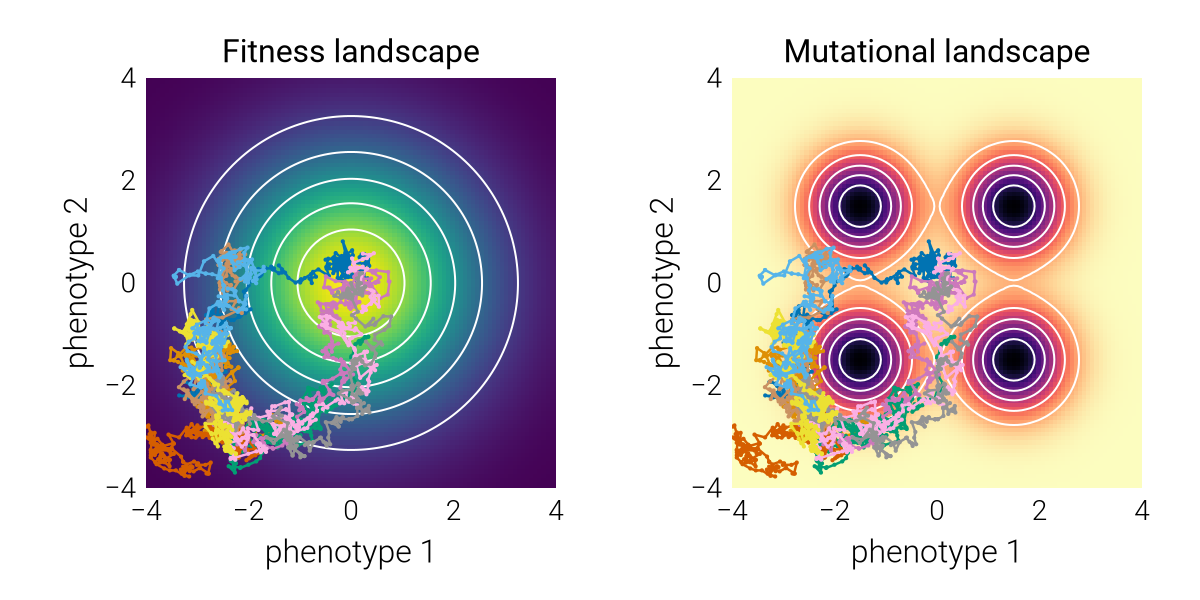

In [24]:
Random.seed!(42)

# Initialize figure
fig = Figure(size=(600, 300))

# Add axis for fitness landscape
ax1 = Axis(
    fig[1, 1],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    aspect=AxisAspect(1),
    title="Fitness landscape",
)
# Add axis for mutational landscape
ax2 = Axis(
    fig[1, 2],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    aspect=AxisAspect(1),
    title="Mutational landscape",
)

# Plot fitness landscape
heatmap!(ax1, x, y, F)
# Plot heatmap of mutational landscape
heatmap!(ax2, x, y, M, colormap=:magma)

# Plot contour plot
contour!(ax1, x, y, F, color=:white)
contour!(ax2, x, y, M, color=:white)

# Loop over simulations
for (i, x_traj) in enumerate(x_traj_list)
    # Plot trajectory
    scatterlines!.(
        [ax1, ax2],
        Ref(x_traj[1, :]),
        Ref(x_traj[2, :]),
        color=ColorSchemes.seaborn_colorblind[i],
        markersize=3
    )
end

# Set limits
xlims!(ax1, -4, 4)
ylims!(ax1, -4, 4)
xlims!(ax2, -4, 4)
ylims!(ax2, -4, 4)

fig

### Simulate fitnotype profiles

Having evolved the populations on the fitness-mutational landscape, we can
now simulate the fitnotype profiles. For this, we will use a set of random
fitness landscapes and determine the fitness of the evolved populations in each
one of them.

Let's define a set of random fitness landscapes.

In [34]:
Random.seed!(42)

# Define landscape dimensionality
n_dim = 2

# Define number of fitness landscapes
n_fit_lans = 50

# Define range of peak means
peak_mean_min = -4.0
peak_mean_max = 4.0

# Define range of fitness amplitudes
fit_amp_min = 1.0
fit_amp_max = 5.0

# Define covariance range
fit_cov_min = 0.5
fit_cov_max = 3.0

# Define possible number of fitness peaks
n_fit_peaks_min = 1
n_fit_peaks_max = 3

# Initialize array to hold fitness landscapes
fit_lands = []

# Loop over number of fitness landscapes
for _ in 1:n_fit_lans
    # Sample number of fitness peaks
    n_fit_peaks = rand(n_fit_peaks_min:n_fit_peaks_max)

    # Sample fitness means as 2D vectors from uniform distribution
    fit_means = [
        rand(Distributions.Uniform(peak_mean_min, peak_mean_max), 2)
        for _ in 1:n_fit_peaks
    ]

    # Sample fitness amplitudes from uniform distribution
    fit_amplitudes = rand(
        Distributions.Uniform(fit_amp_min, fit_amp_max), n_fit_peaks
    )

    # Sample fitness covariances from uniform distribution
    fit_covariances = rand(
        Distributions.Uniform(fit_cov_min, fit_cov_max), n_fit_peaks
    )

    # Create fitness peaks
    fit_peaks = mh.GaussianPeak.(
        fit_amplitudes, fit_means, fit_covariances .* Ref(LinearAlgebra.I(n_dim))
    )

    # Append fitness landscape to array
    push!(fit_lands, fit_peaks)
end

Let's now plot some ofthe fitness landscapes in a grid.

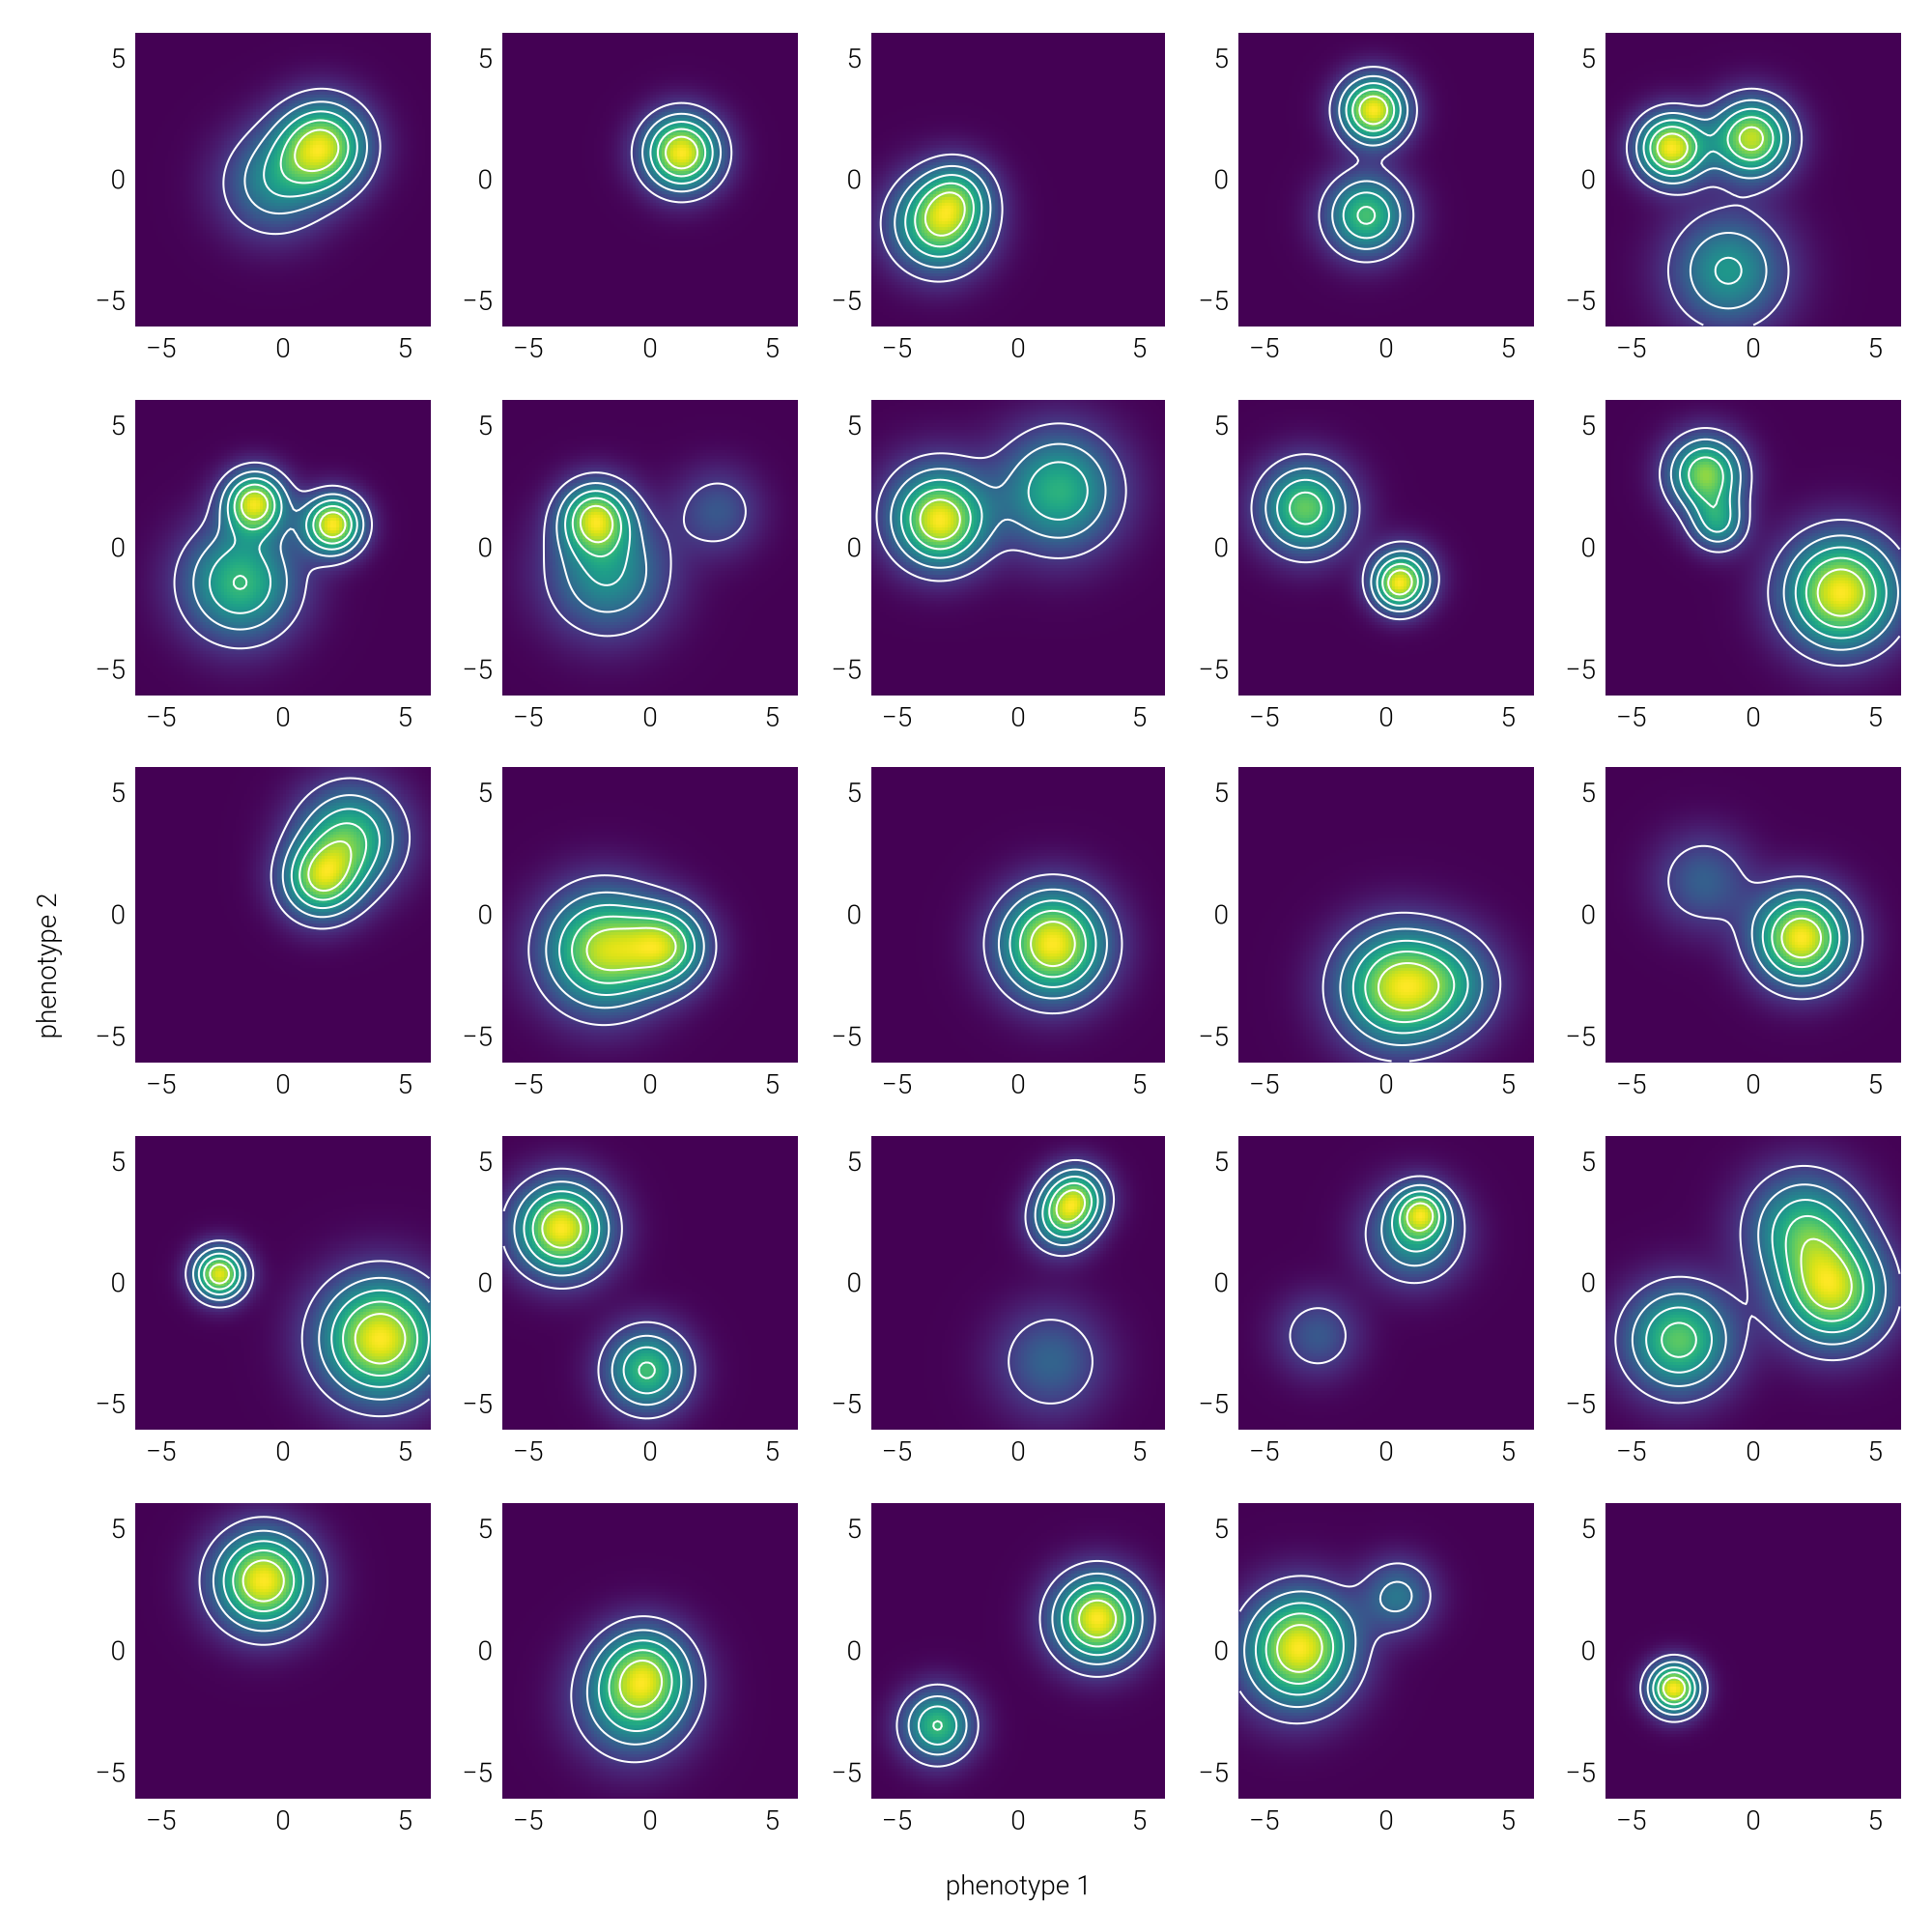

In [36]:
# Define number of rows and columns
n_rows = 5
n_cols = 5

# Define ranges of phenotypes to evaluate
x = range(-6, 6, length=100)
y = range(-6, 6, length=100)

# Initialize figure
fig = Figure(size=(200 * n_cols, 200 * n_rows))

# Add grid layout
gl = fig[1, 1] = GridLayout()

# Loop over fitness landscapes
for i in 1:(n_rows*n_cols)
    # Extract fitness landscape
    fit_land = fit_lands[i]
    # Define row and column
    row = (i - 1) ÷ n_cols + 1
    col = (i - 1) % n_cols + 1
    # Add axis
    ax = Axis(gl[row, col], aspect=AxisAspect(1))
    # Evaluate fitness landscape
    F = mh.fitness.([[x, y] for x in x, y in y], Ref(fit_land))
    # Plot fitness landscape
    heatmap!(ax, x, y, F, colormap=:viridis)
    # Plot contour plot
    contour!(ax, x, y, F, color=:white)
end

# Add global x and y labels
Label(gl[end+1, :], "phenotype 1")
Label(gl[:, 0], "phenotype 2", rotation=π / 2)

fig


With these fitness landscapes, we can now determine the fitness of the evolved
populations in each one of them.

In [37]:
# Initialize array to hold fitness values
fitnotype_profiles = Array{Float32,3}(undef, n_fit_lans, n_sim, n_steps + 1)

# Loop over fitness landscapes
for (i, fit_land) in enumerate(fit_lands)
    # Loop over simulations
    for (j, x_traj) in enumerate(x_traj_list)
        # Determine fitness of evolved population in fitness landscape
        fitnotype_profiles[i, j, :] = mh.fitness(x_traj, fit_land)
    end # for i
end # for k

### Exploratory analysis of fitnotype profiles

Now that we have the fitnotype profiles, we can perform an exploratory analysis
of them.

Let's begin by plotting the fitness profiles across all environments for a few
sample time points.

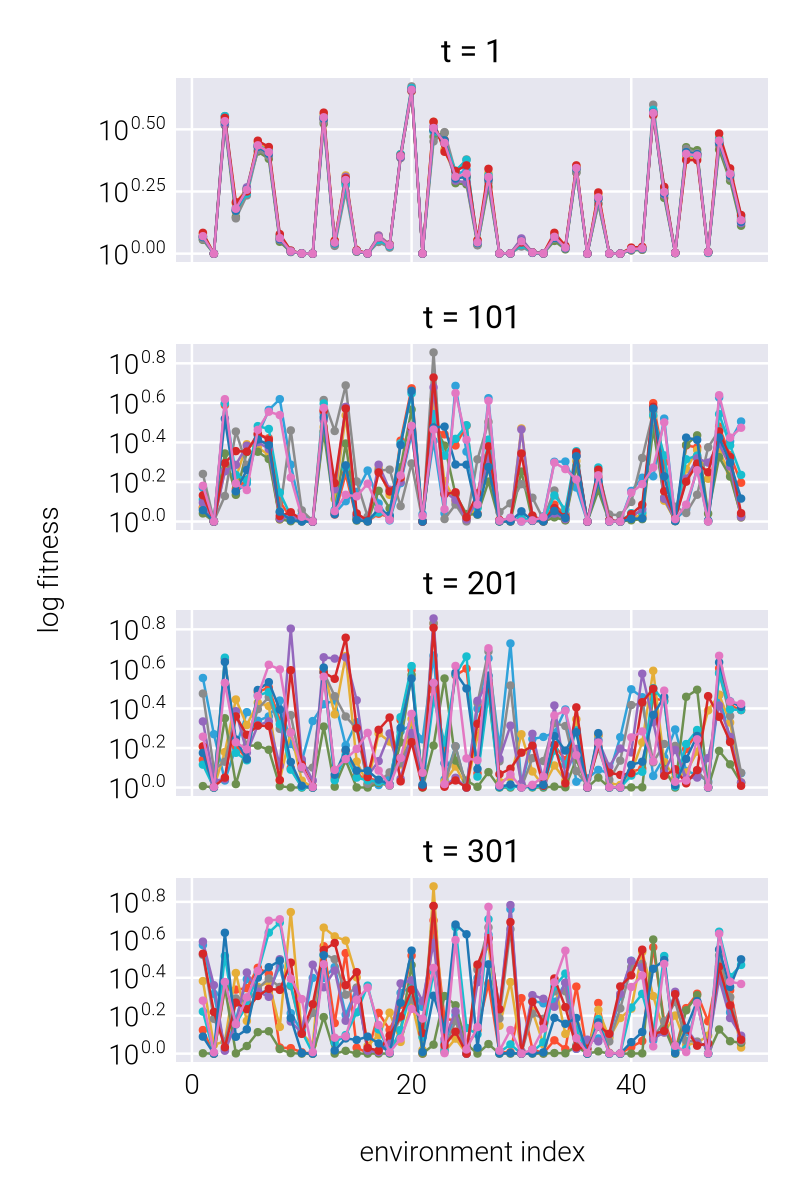

In [77]:
# Define number of time points to plot
n_tps_plot = 4

# Define time point indices to plot as evenly spaced as possible
tps_plot = Int.(range(1, n_steps + 1, length=n_tps_plot))

# Initialize figure
fig = Figure(size=(400, 150 * n_tps_plot))

# Add grid layout for entire figure
gl = fig[1, 1] = GridLayout()

# Add grid layout for plots
gl_plots = gl[1:5, 1:5] = GridLayout()

# Loop over time points
for (i, tp) in enumerate(tps_plot)
    # Add axis
    ax = Axis(
        gl_plots[i, 1],
        title="t = $tp",
        yscale=log10,
    )
    # Check if final plot
    if i ≠ n_tps_plot
        # Turn off x-axis
        hidexdecorations!(ax, grid=false)
    end
    # Loop over simulations
    for j in 1:size(fitnotype_profiles, 2)
        # Plot fitness profile
        scatterlines!(
            ax,
            1:size(fitnotype_profiles, 1),
            fitnotype_profiles[:, j, tp],
            color=ColorSchemes.glasbey_hv_n256[j],
            markersize=6
        )
    end # for j
end # for i

# Add global x and y labels
Label(gl[end+1, 3], "environment index")
Label(gl[3, 0], "log fitness", rotation=π / 2)
fig

From this type of plot is hard to see the dynamics of the fitness across
environments. Let's try performing a PCA on the fitness profiles via SVD.

In [92]:
# Reshape the array to stack the 3rd dimension
fit_mat = log.(reshape(fitnotype_profiles, size(fitnotype_profiles, 1), :))

# Fit model to standardize data to mean zero and standard deviation 1 on each
# environment 
dt = StatsBase.fit(StatsBase.ZScoreTransform, fit_mat, dims=2)

# Standardize the data to have mean 0 and standard deviation 1
fit_std = StatsBase.transform(dt, fit_mat)

# Compute SVD
U, S, V = LinearAlgebra.svd(fit_std);

Let's now plot the singular values profile as well as the percentage of variance
explained by each principal component.

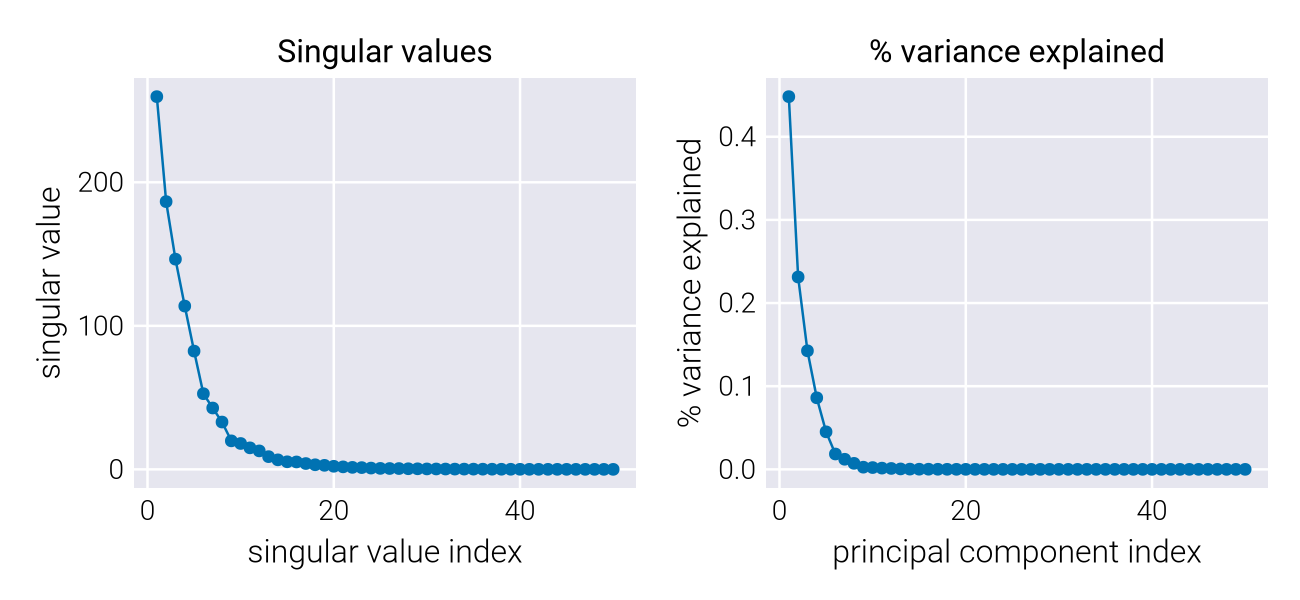

In [102]:
# Initialize figure
fig = Figure(size=(650, 300))

# Add axis for singular values
ax1 = Axis(
    fig[1, 1],
    title="Singular values",
    xlabel="singular value index",
    ylabel="singular value",
)

# Plot singular values
scatterlines!(ax1, S)

# Add axis for percentage of variance explained
ax2 = Axis(
    fig[1, 2],
    title="% variance explained",
    xlabel="principal component index",
    ylabel="% variance explained",
)
# Compute percentage of variance explained
pve = S .^ 2 ./ sum(S .^ 2)
# Plot percentage of variance explained
scatterlines!(ax2, pve)

fig

From these plots we can see that the first two principal components explain most
of the variance in the data with $\approx$ 45% of the variance explained by the
first principal component and $\approx$ 25% by the second.

Let's project the data onto the first two principal components and plot the
results.

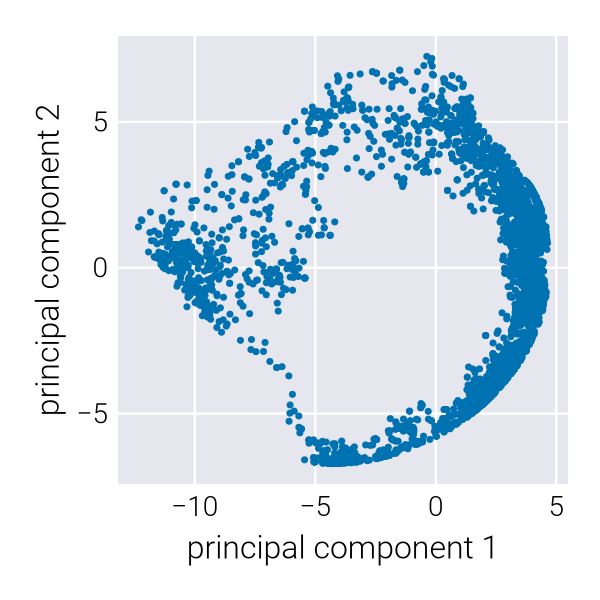

In [108]:
# Project data onto first two principal components
fit_pca = U[:, 1:2]' * fit_std

# Initialize figure
fig = Figure(size=(300, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="principal component 1",
    ylabel="principal component 2",
    aspect=AxisAspect(1),
)

# Plot fitness profiles
scatter!(ax, fit_pca[1, :], fit_pca[2, :], markersize=5)

fig

This structure really resembles the trajectories in the fitness/mutational
landscape space. To confirm that is the case, let's try to color each point by
the strain index and see if we can see the similarity in the dynamics in both
spaces.

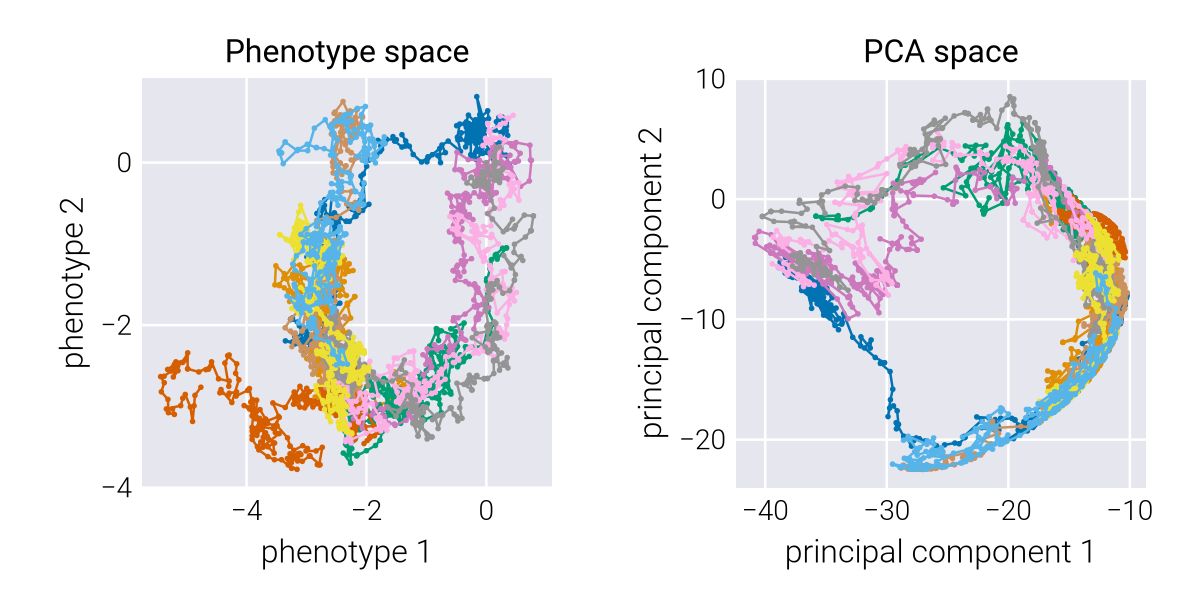

In [148]:
# Standardize each slice of the fitnotype profiles
fit_pca_std = reduce(
    (x, y) -> cat(x, y, dims=3),
    StatsBase.transform.(Ref(dt), eachslice(fitnotype_profiles, dims=3))
)

# Initialize figure
fig = Figure(size=(600, 300))

# Add axis for original space
ax1 = Axis(
    fig[1, 1],
    title="Phenotype space",
    aspect=AxisAspect(1),
    xlabel="phenotype 1",
    ylabel="phenotype 2",
)

# Add axis for PCA space
ax2 = Axis(
    fig[1, 2],
    title="PCA space",
    aspect=AxisAspect(1),
    xlabel="principal component 1",
    ylabel="principal component 2",
)


# Loop over simulations
for (i, x_traj) in enumerate(x_traj_list)
    # Plot trajectory
    scatterlines!(
        ax1,
        x_traj[1, :],
        x_traj[2, :],
        color=ColorSchemes.seaborn_colorblind[i],
        markersize=4
    )
end

# Loop through each simulation (2nd dimension)
for (j, slice) in enumerate(eachslice(fit_pca_std, dims=2))
    # Project slice onto PCA space
    pca_slice = U[:, 1:2]' * slice
    # Plot slice
    scatterlines!(
        ax2,
        pca_slice[1, :],
        pca_slice[2, :],
        color=ColorSchemes.seaborn_colorblind[j],
        markersize=4
    )
end

fig